In [63]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task Setup

In [65]:
task_vars = rl.task.TaskVars()
task_vars.n_trials = 100
task_vars.n_blocks = 2
task = rl.task.Task(task_vars=task_vars)
task

Task with the task rules:
  {'0': {'p_r_0': 0.2, 'p_r_1': 0.8, 'a_correct': [1]}, '1': {'p_r_0': 0.8, 'p_r_1': 0.2, 'a_correct': [0]}}

# Agent

In [83]:
agent_vars = rl.agent.AgentVars()
agent_vars.beta = 3
agent_vars.alpha_win = 0.7
agent_vars.alpha_loss = 0.4
agent = rl.agent.Agent(agent_vars=agent_vars)
agent

Dual learning rate agent with
  alpha_win = 0.7
  alpha_loss = 0.4
  beta = 3

# Interaction

Let the agent perform the task.

In [84]:
np.random.seed(1)
df = rl.interaction.agent_task_interaction(task, agent)
df.head()

,trial,block,rule,p_r_0,p_r_1,r,a,corr,p_a0,p_a1,v_a_0,v_a_1,ll
0,0.0,0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.5,0.5,0.0,0.0,-0.693147
1,1.0,0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.5,0.5,0.0,0.0,-0.693147
2,2.0,0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.5,0.5,0.0,0.0,-0.693147
3,3.0,0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.5,0.5,0.0,0.0,-0.693147
4,4.0,0.0,0.0,0.2,0.8,0.0,0.0,0.0,0.5,0.5,0.0,0.0,-0.693147


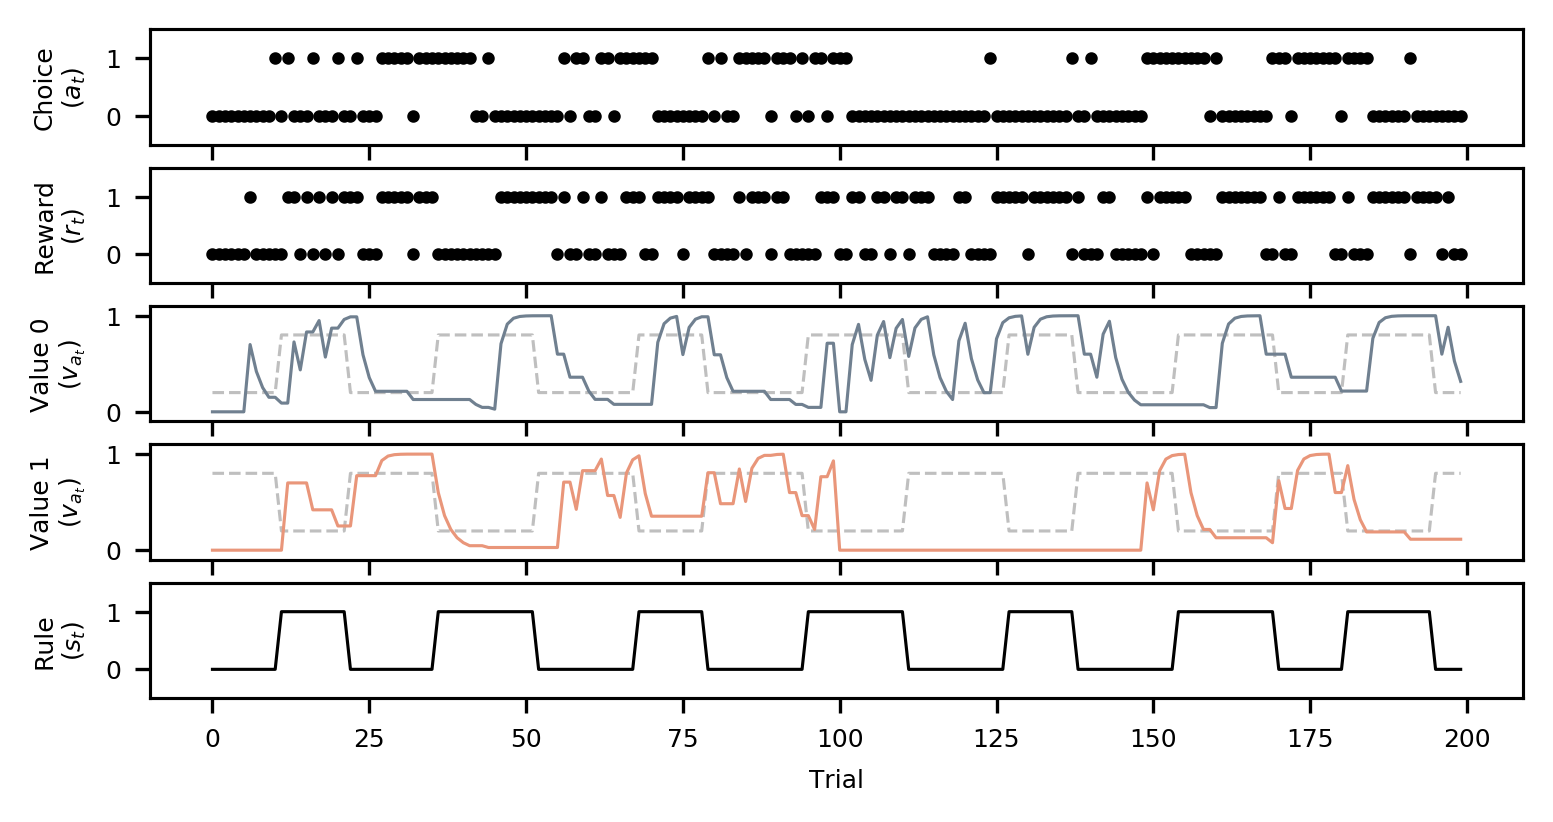

In [85]:
rl.plots.plot_data(data=df);

# Estimation

In [86]:
from rl.estimation import Estimation, EstimationVars

In [91]:
est_vars = EstimationVars(task_vars)
est_vars.n_sp = 10
est = Estimation(est_vars)

In [92]:
agent

Dual learning rate agent with
  alpha_win = 0.7
  alpha_loss = 0.4
  beta = 3

In [93]:
est.llh(x=[agent.agent_vars.alpha_win,
           agent.agent_vars.alpha_loss,
           agent.agent_vars.beta],
        data=df,
        agent_vars=agent_vars)

90.68597263847757

In [94]:
result = est.estimate(data=df)
result

(89.52275310471468,
 -97.47022915453674,
 [0.7353823729458804, 0.26482508382378633, 3.149570492544184])

# Recovery

In [172]:
# Set up task
task_vars = rl.task.TaskVars()
task_vars.n_trials = 100
task_vars.n_blocks = 2
task = rl.task.Task(task_vars=task_vars)

In [173]:
# Set up agent
agent_vars = rl.agent.AgentVars()
agent_vars.alpha_win = np.nan
agent_vars.alpha_loss = np.nan
agent_vars.beta = np.nan
agent = rl.agent.Agent(agent_vars=agent_vars)

In [174]:
# Set up parameter ranges
alpha_win_values = {'var': np.arange(0, 1.01, 0.2), 'lo':0.1, 'md':0.5, 'hi':0.8}
alpha_loss_values = {'var': np.arange(0, 1.01, 0.2), 'lo':0.1, 'md':0.5, 'hi':0.8}
beta_values = {'var':np.arange(1, 10, 2), 'lo':1, 'md':5, 'hi':10}
parameter_values = {'alpha_win':alpha_win_values,
              'alpha_loss':alpha_loss_values,
              'beta':beta_values}

In [178]:
# Set up estimation
est_vars = rl.estimation.EstimationVars(task_vars=task_vars)
est_vars.n_sp = 1
est = rl.estimation.Estimation(est_vars=est_vars)

In [179]:
from tqdm.notebook import tqdm

In [181]:
n_recovs = (3 * 3 * len(alpha_win_values['var']) +
            3 * 3 * len(alpha_loss_values['var']) +
            3 * 3 * len(beta_values['var']))

pbar = tqdm(total=n_recovs)

recovery_results = []

i = 0

parameter_names = ['alpha_win', 'alpha_loss', 'beta']

parameters = {'alpha_win': np.nan,
             'alpha_loss': np.nan,
             'beta': np.nan}

for var in parameter_names:
    others = [p for p in parameter_names
              if p != var]

    for other0_val in ['lo', 'md', 'hi']:
        for other1_val in ['lo', 'md', 'hi']:
            parameters[others[0]] = parameter_values[others[0]][other0_val]
            parameters[others[1]] = parameter_values[others[1]][other1_val]
    
            for v in parameter_values[var]['var']:
                parameters[var] = v

                agent.agent_vars.alpha_win = parameters['alpha_win']
                agent.agent_vars.alpha_loss = parameters['alpha_loss']
                agent.agent_vars.beta = parameters['beta']

                data = rl.interaction.agent_task_interaction(task, agent)

                nll, bic, (alpha_win_hat, alpha_loss_hat, beta_hat) = est.estimate(data=data, seed=i)

                result = pd.DataFrame(dict(
                    variable=var,
                    alpha_win=parameters['alpha_win'],
                    alpha_loss=parameters['alpha_loss'],
                    beta=parameters['beta'],
                    alpha_win_hat=alpha_win_hat,
                    alpha_loss_hat=alpha_loss_hat,
                    beta_hat=beta_hat,
                    n_trials=task.task_vars.n_trials,
                    n_blocks=task.task_vars.n_blocks,
                    n_sp=est.est_vars.n_sp),
                    index=[i])
                result[f"{var}_level"] = 'var'
                result[f"{others[0]}_level"] = other0_val
                result[f"{others[1]}_level"] = other1_val
                

                recovery_results.append(result)

                i +=1
                pbar.update()

recovery_results = pd.concat(recovery_results)
recovery_results.to_csv('recovery-results.csv')

In [183]:
recovery_results.head()

,variable,alpha_win,alpha_loss,beta,alpha_win_hat,alpha_loss_hat,beta_hat,n_trials,n_blocks,n_sp,alpha_win_level,alpha_loss_level,beta_level
0,alpha_win,0.0,0.1,1,0.000000,0.000000,0.000000,100,2,1,var,lo,lo
1,alpha_win,0.2,0.1,1,0.809227,0.312640,0.616428,100,2,1,var,lo,lo
2,alpha_win,0.4,0.1,1,0.156039,0.044482,1.345277,100,2,1,var,lo,lo
3,alpha_win,0.6,0.1,1,0.000000,0.000000,0.000000,100,2,1,var,lo,lo
4,alpha_win,0.8,0.1,1,0.000000,0.000000,0.000000,100,2,1,var,lo,lo


In [249]:
def plot_recovery_results(recovery_results, variable_parameter, bounds=None, ticks=None):

    fig, axs = plt.subplots(3, 3, figsize=rl.plot_utils.cm2inch(9, 9),
                            sharex=True, sharey=True)
    
    parameter_names = ['alpha_win', 'alpha_loss', 'beta']
    others = [p for p in parameter_names
              if p != variable_parameter]

    df = recovery_results.loc[recovery_results['variable'] == variable_parameter]            
    
    for i, other0_val in enumerate(['lo', 'md', 'hi']):
        for j, other1_val in enumerate(['lo', 'md', 'hi']):
            label = f"{others[0]}: {other0_val}\n{others[1]}: {other1_val}"
            
            ax = axs[i, j]
            ax.set_title(label)
            
            df_ij = df.loc[(df[f"{others[0]}_level"] == other0_val) & 
                           (df[f"{others[1]}_level"] == other1_val)]
            
            ax.plot(df_ij[f"{variable_parameter}"],
                    df_ij[f"{variable_parameter}_hat"],
                    'o', markeredgewidth=0.25)
            
            if ticks is not None:
                ax.set_xticks(ticks)
                ax.set_yticks(ticks)

            
            if bounds is None:
                bounds = [df_ij[[variable_parameter, f"{variable_parameter}_hat"]].values.min(),
                          df_ij[[variable_parameter, f"{variable_parameter}_hat"]].values.max()]
            ax.set_xlim(bounds)
            ax.set_ylim(bounds)

            ax.plot(ax.get_xlim(), ax.get_ylim(),
                    '-', color='black', alpha=0.25, zorder=-1)


            
            
    for ij in range(3):
        axs[-1, ij].set_xlabel('Gen.')
        axs[ij, 0].set_ylabel('Rec.')

    fig.tight_layout()
    fig.suptitle(variable_parameter, y=1.05, fontweight='bold')
    
    return fig, axs

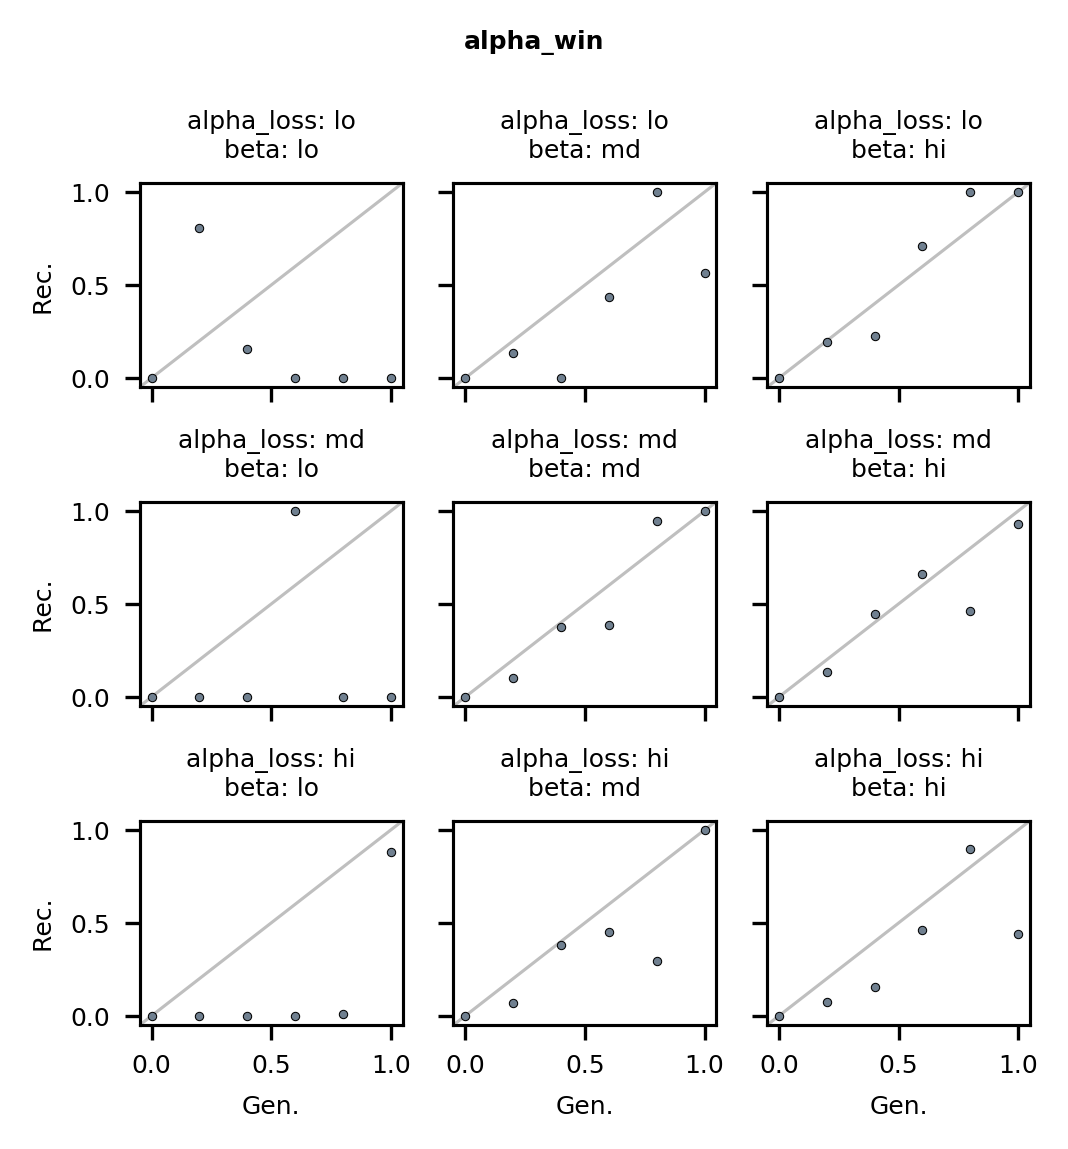

In [250]:
plot_recovery_results(recovery_results,
                      'alpha_win',
                      ticks=np.linspace(0, 1, 3),
                      bounds=[-0.05, 1.05]);

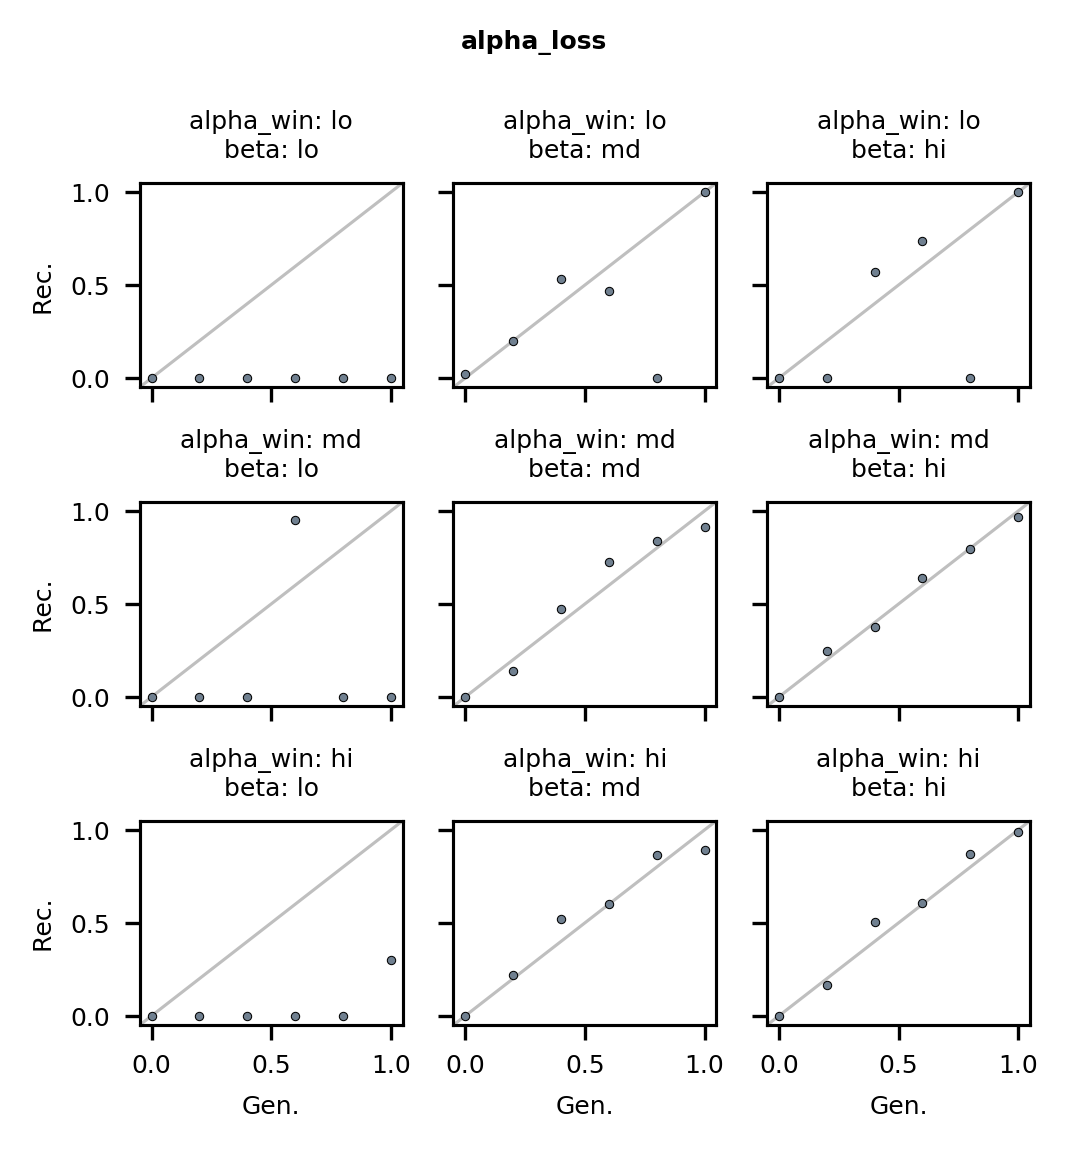

In [253]:
plot_recovery_results(recovery_results,
                      'alpha_loss',
                      ticks=np.linspace(0, 1, 3),
                      bounds=[-0.05, 1.05]);

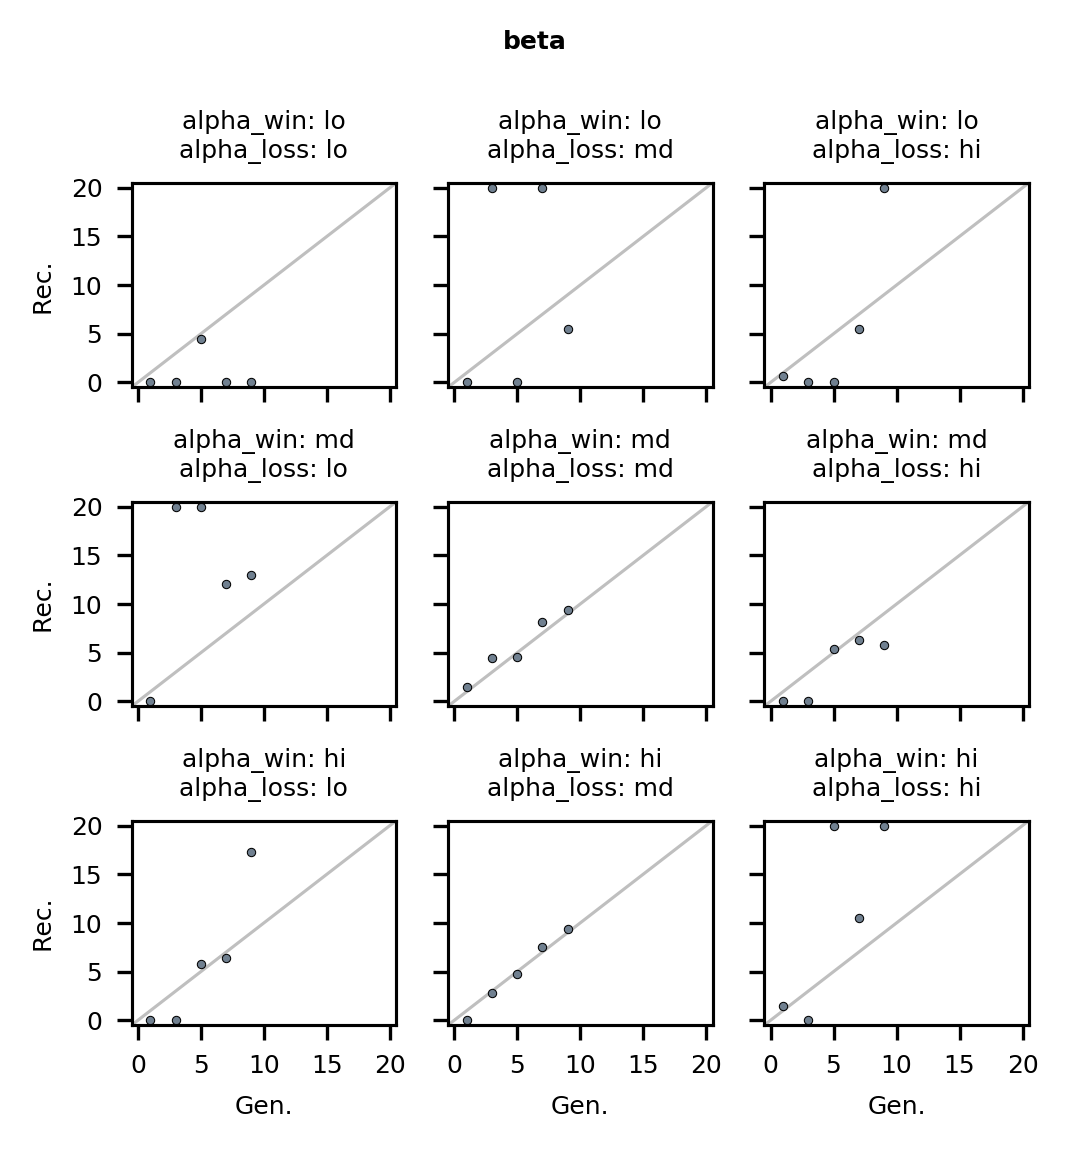

In [257]:
plot_recovery_results(recovery_results,
                      'beta',
                      ticks=np.linspace(0, 20, 5),
                      bounds=[-0.5, 20.5]);